In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

In [4]:
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [5]:
train_df.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [6]:
train_df.shape

(18524, 9)

In [7]:
test_df.shape

(6175, 8)

In [8]:
train_df.head(10)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
5,5,2.0,No,8.0,5.0,No,NaN,3.0,Extrovert
6,6,1.0,No,8.0,NaN,No,NaN,4.0,Extrovert
7,7,2.0,No,8.0,3.0,No,4.0,5.0,Extrovert
8,8,4.0,Yes,2.0,1.0,NaN,0.0,2.0,Introvert
9,9,1.0,No,8.0,6.0,No,14.0,9.0,Extrovert


In [9]:
test_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [10]:
train_df.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [11]:
test_df.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

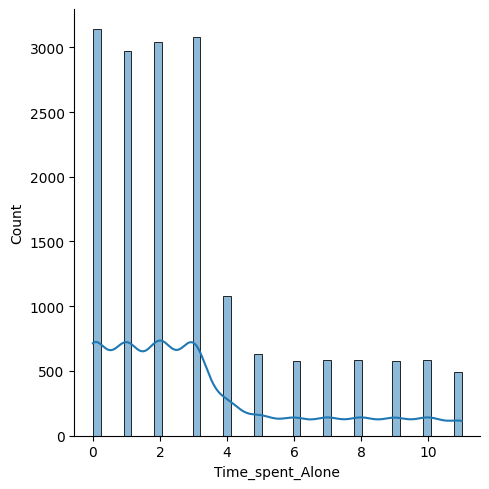

In [12]:
sns.displot(train_df['Time_spent_Alone'],kde = True)

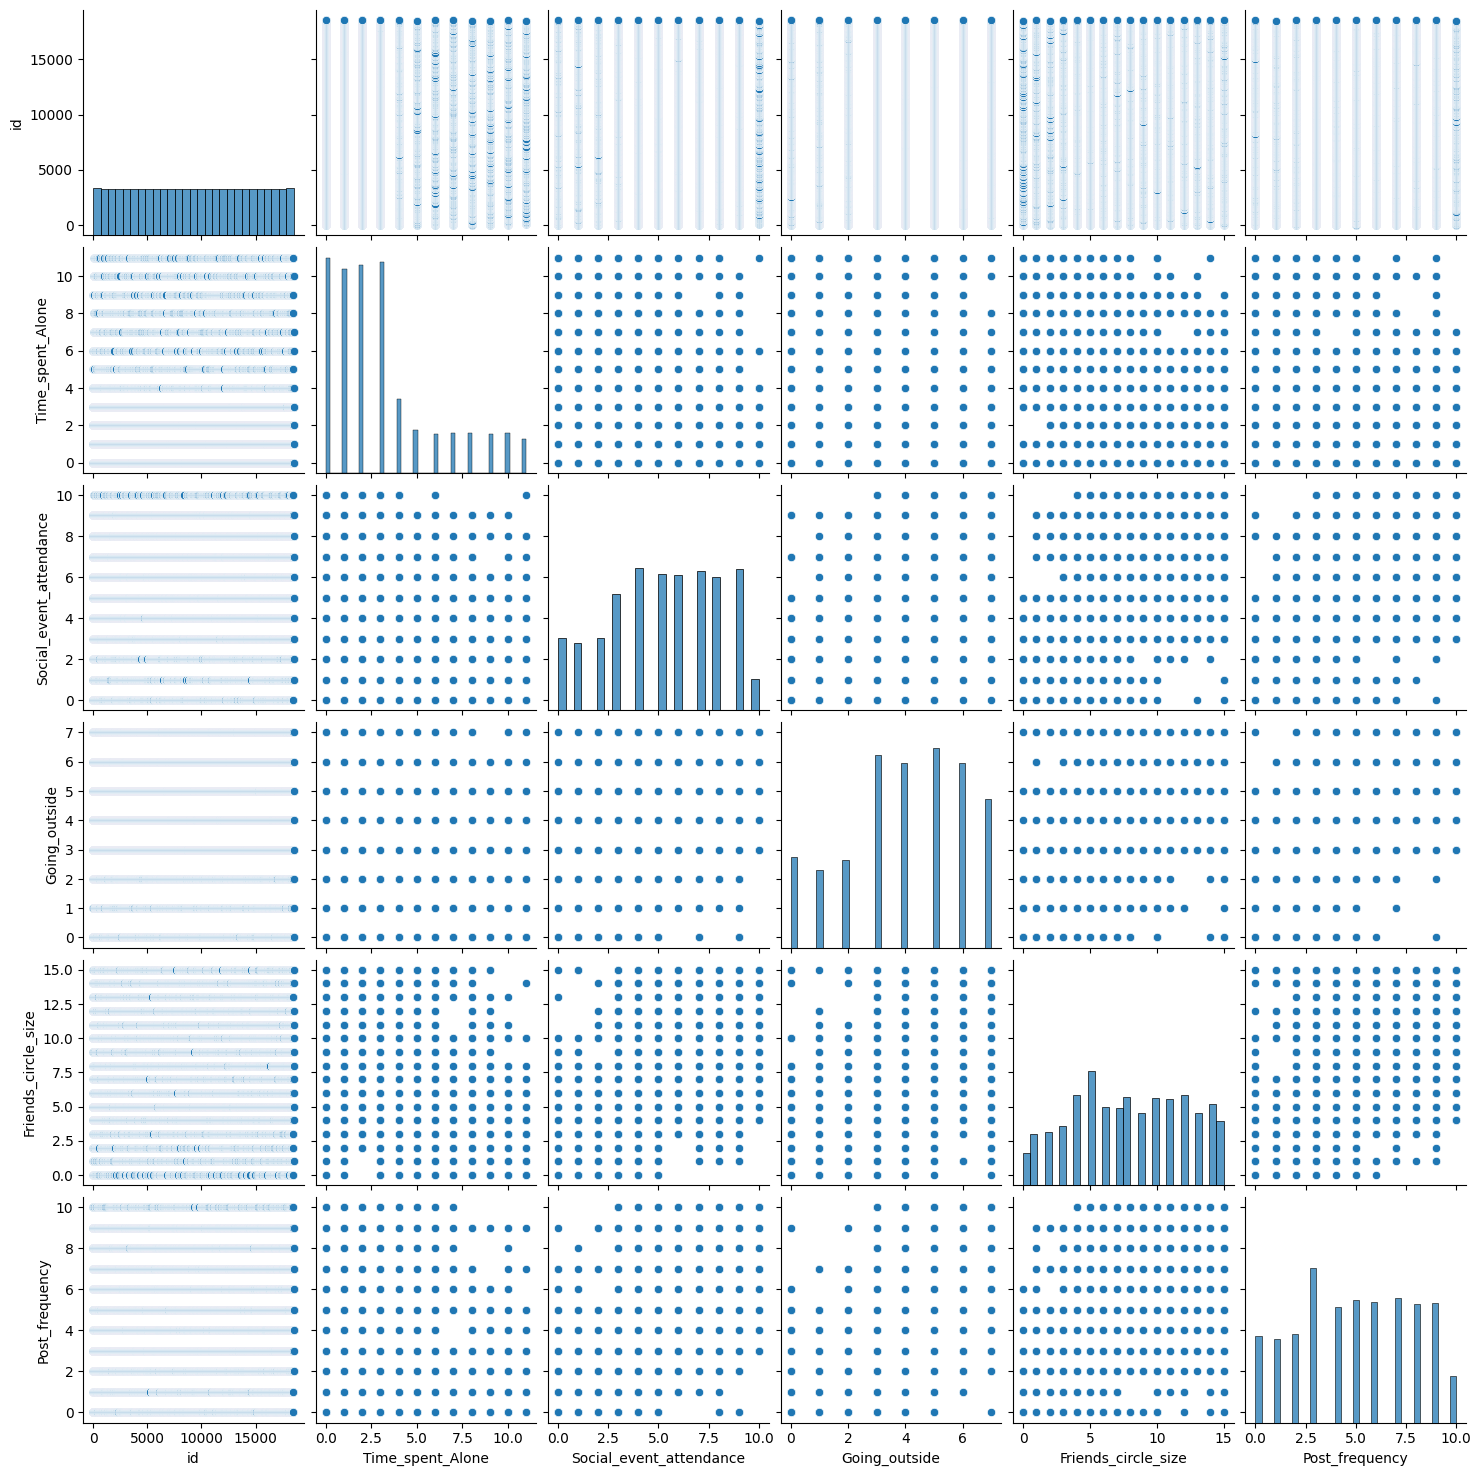

In [13]:
sns.pairplot(train_df)
plt.show()

Text(0.5, 1.0, 'Social_event_attendance vs Personlaity')

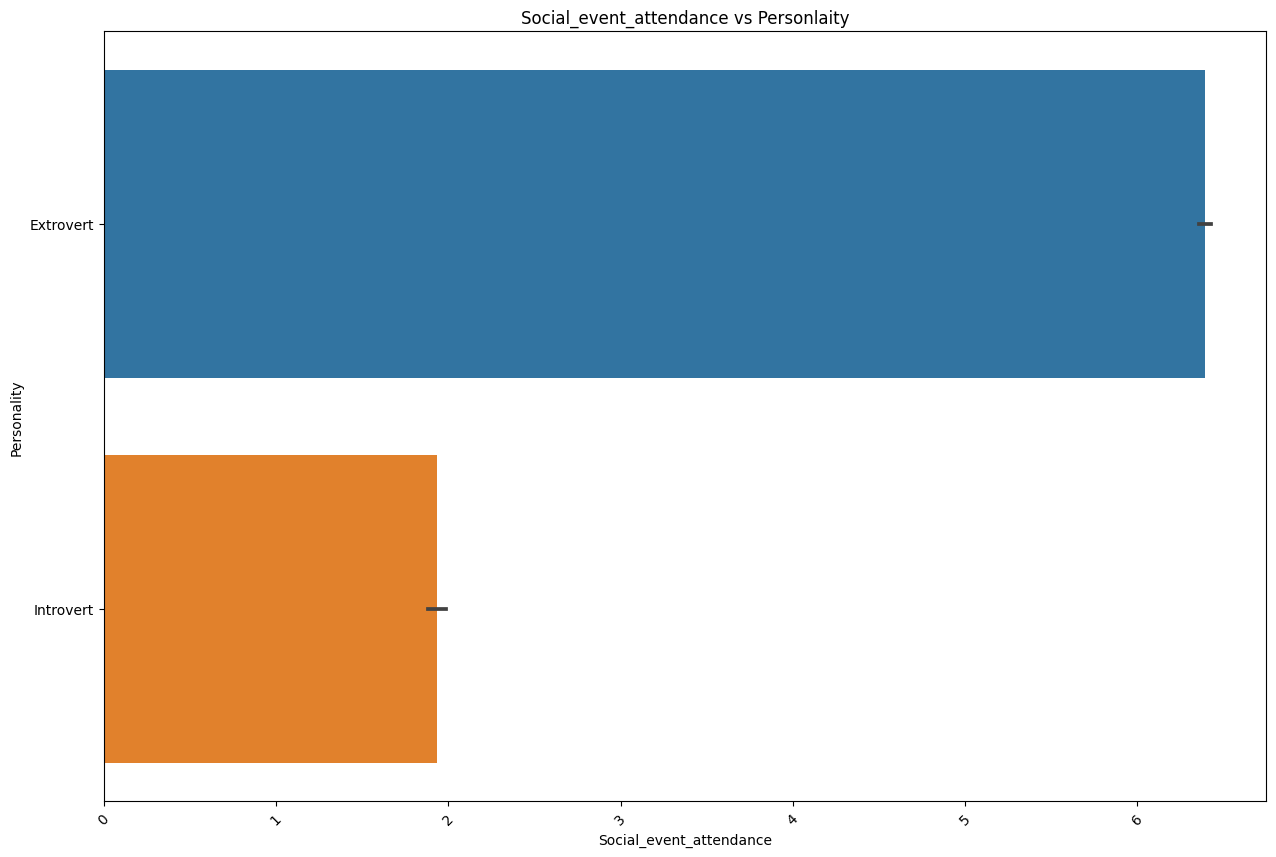

In [14]:
plt.figure(figsize=(15,10))
sns.barplot(x=train_df['Social_event_attendance'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Social_event_attendance')
plt.ylabel('Personality')
plt.title('Social_event_attendance vs Personlaity')

Text(0.5, 1.0, 'Time_spent_Alone vs Personlaity')

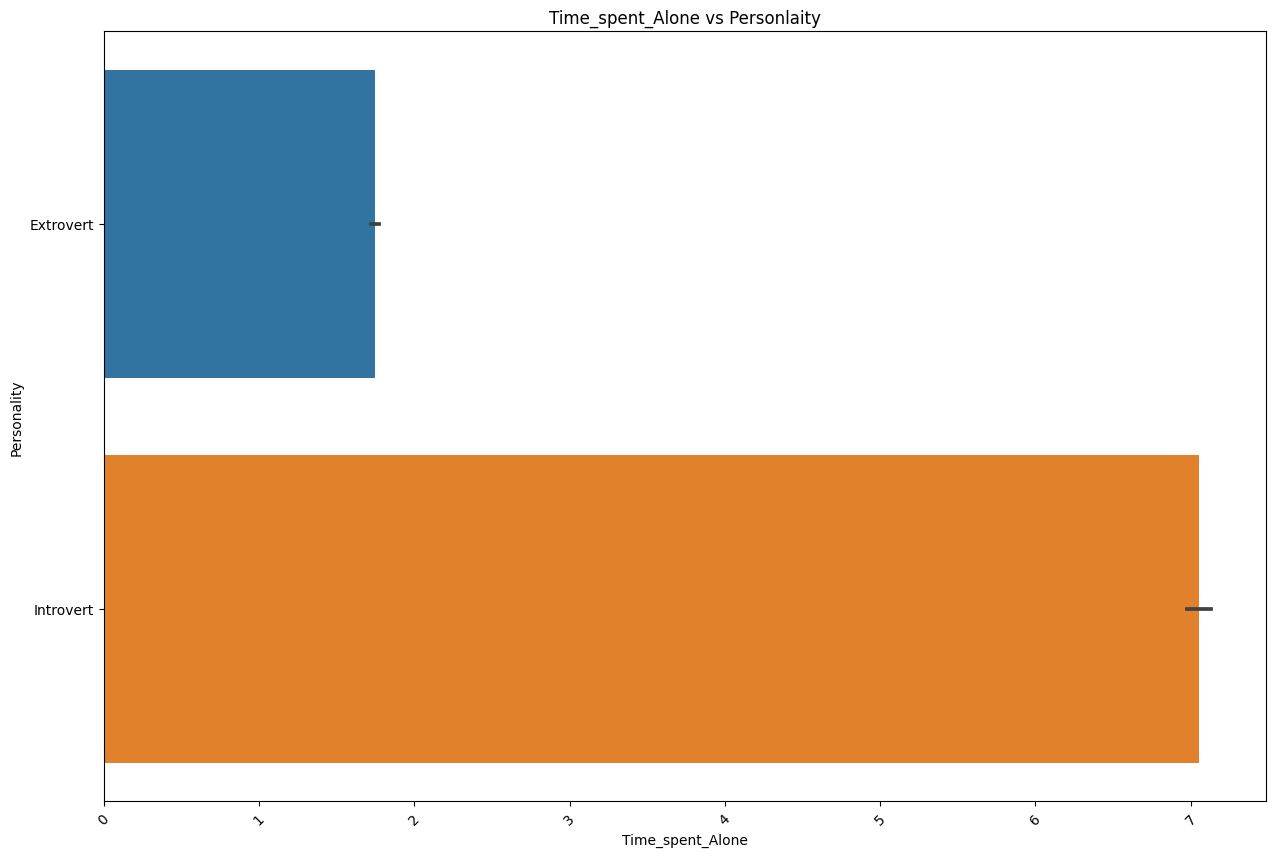

In [15]:
plt.figure(figsize=(15,10))
sns.barplot(x=train_df['Time_spent_Alone'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Time_spent_Alone')
plt.ylabel('Personality')
plt.title('Time_spent_Alone vs Personlaity')

Text(0.5, 1.0, 'Going_outside vs Personlaity')

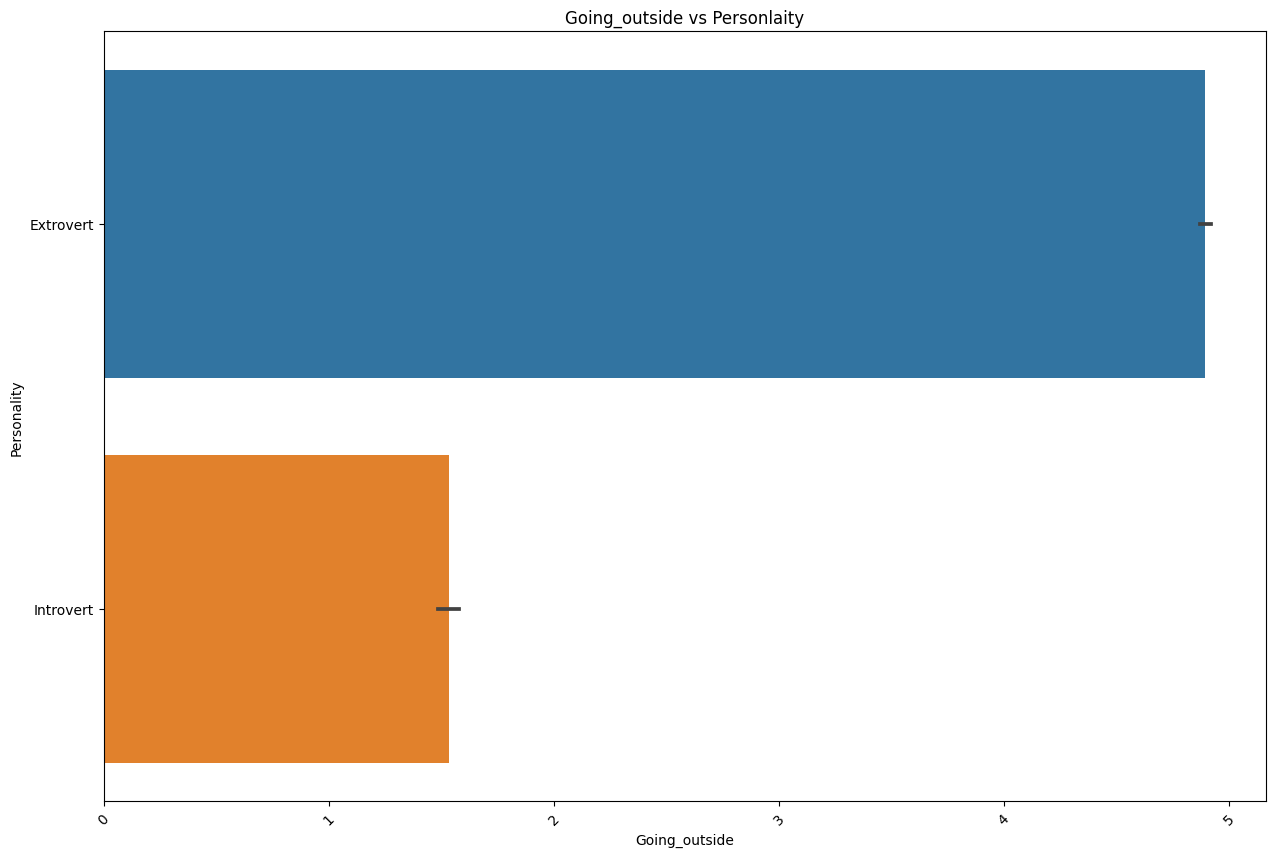

In [16]:
plt.figure(figsize=(15,10))
sns.barplot(x=train_df['Going_outside'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Going_outside')
plt.ylabel('Personality')
plt.title('Going_outside vs Personlaity')

Text(0.5, 1.0, 'Friends_circle_size vs Personlaity')

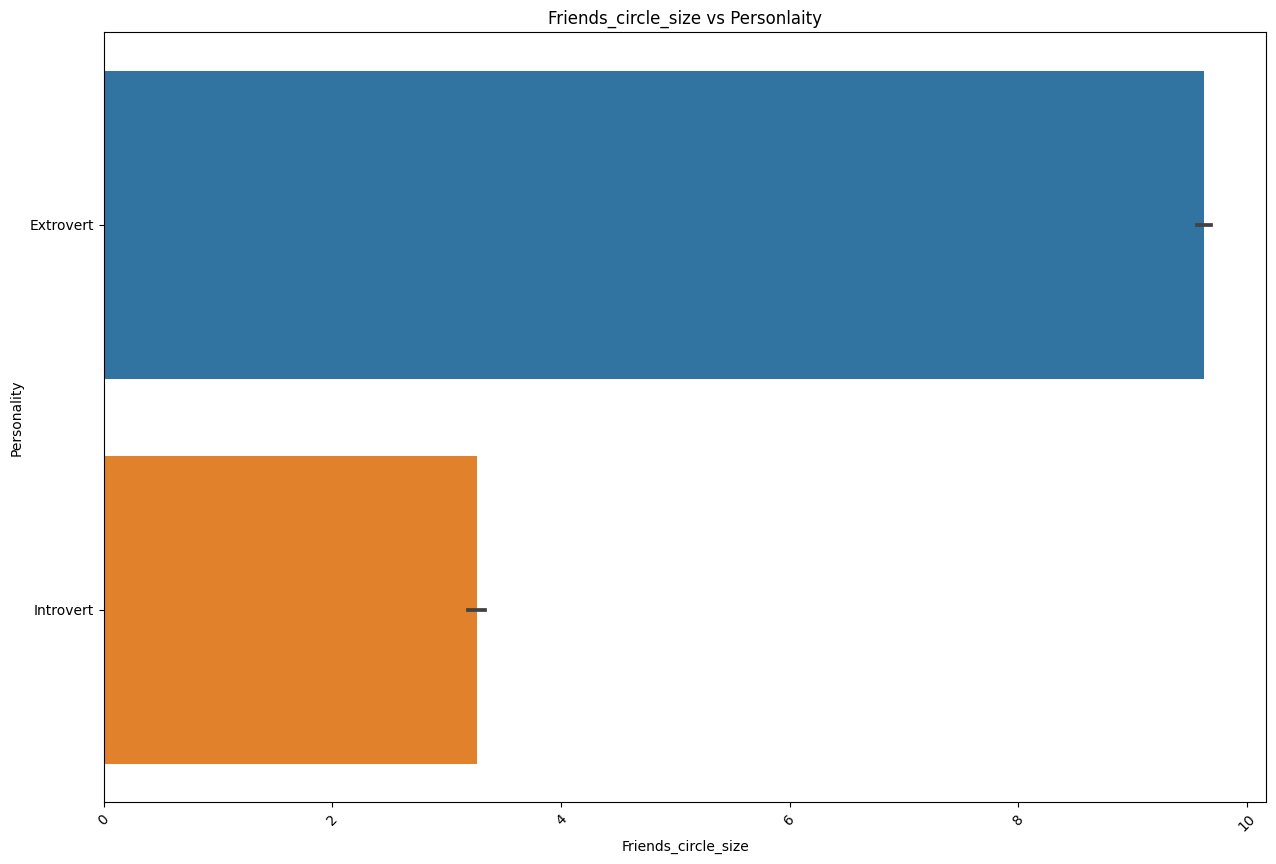

In [17]:
plt.figure(figsize=(15,10))
sns.barplot(x=train_df['Friends_circle_size'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Friends_circle_size')
plt.ylabel('Personality')
plt.title('Friends_circle_size vs Personlaity')

In [18]:
lenc = LabelEncoder()

In [19]:
train_df['Stage_fear'] = lenc.fit_transform(train_df['Stage_fear'])

In [20]:
test_df['Stage_fear'] = lenc.fit_transform(test_df['Stage_fear'])

In [21]:
train_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,0,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,1,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,0,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,0,4.0,4.0,No,13.0,NaN,Extrovert


In [22]:
train_df['Drained_after_socializing'] = lenc.fit_transform(train_df['Drained_after_socializing'])

In [23]:
train_df['Personality'] = lenc.fit_transform(train_df['Personality'])

In [24]:
train_df.head(10)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0,6.0,4.0,0,15.0,5.0,0
1,1,1.0,0,7.0,3.0,0,10.0,8.0,0
2,2,6.0,1,1.0,0.0,2,3.0,0.0,1
3,3,3.0,0,7.0,3.0,0,11.0,5.0,0
4,4,1.0,0,4.0,4.0,0,13.0,NaN,0
5,5,2.0,0,8.0,5.0,0,NaN,3.0,0
6,6,1.0,0,8.0,NaN,0,NaN,4.0,0
7,7,2.0,0,8.0,3.0,0,4.0,5.0,0
8,8,4.0,1,2.0,1.0,2,0.0,2.0,1
9,9,1.0,0,8.0,6.0,0,14.0,9.0,0


In [25]:
test_df['Drained_after_socializing'] = lenc.fit_transform(test_df['Drained_after_socializing'])

In [26]:
test_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,0,7.0,4.0,0,6.0,NaN
1,18525,NaN,1,0.0,0.0,1,5.0,1.0
2,18526,3.0,0,5.0,6.0,0,15.0,9.0
3,18527,3.0,0,4.0,4.0,0,5.0,6.0
4,18528,9.0,1,1.0,2.0,1,1.0,1.0
